In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
from pickle import dump
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv1D, MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping
import mlflow.keras
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

Using TensorFlow backend.


In [2]:
# Set random seed for data splitting
np.random.seed(7)

In [3]:
def create_sequences(dataset, in_steps=1, out_steps=1, dropNa=True):
    """Converts time series into a data set for supervised machine learning models"""
    # drop row's which include Nan elements (data preprocessing)
    df = pd.DataFrame(dataset)
    if dropNa:
        df.dropna(inplace=True)
    dataset = df.values
    # create x and y out of dataset
    dataX, dataY = [], []
    for i in range(len(dataset)):
        endIdx = i + in_steps + out_steps
        # stop if reached the end of dataset
        if endIdx > len(dataset):
            break
        dataX.append(dataset[i:endIdx-out_steps, :])
        dataY.append(dataset[endIdx-out_steps:endIdx, :])
    return np.array(dataX), np.array(dataY)

In [4]:
def test_train(datasetsize, testsize, shuffle=True):
    """Returns two dataset to train and test machine learning models"""
    if shuffle:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        np.random.shuffle(idx)
        train_index = idx[ntest:]
        test_index = idx[:ntest]
        return train_index, test_index
    else:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        test_index = idx[datasetsize - ntest:]
        train_index = idx[:datasetsize - ntest]
        return train_index, test_index

## Model setup

In [47]:
def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu',input_shape=(n_steps,n_feats)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    #model.add(Dropout(0.20))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

In [137]:
def build_model_lstm(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(n_steps,n_feats)))
    #model.add(LSTM(units=128, return_sequences=False, input_shape=(n_steps,n_feats)))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.20))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=n_fore))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

## Importing the data

In [138]:
# Reading the dataset
dataset = pd.read_csv('../data/Forecast Data/dataset.csv')
dataset['DATE'] = [datetime.strptime(date, '%Y-%m-%d') for date in dataset['DATE']]
dataset = dataset.set_index('DATE')

# Throw an exception when containing NaN values
if dataset.isnull().sum().sum() != 0:
    raise Exception("The dataset contains NaN values")

In [142]:
# Preprocessing setup
logging = False
n_steps = 8
output_len = 4
dropNan = False
shuffle = True

Start training model for:  Olympia-Eissportzentrum


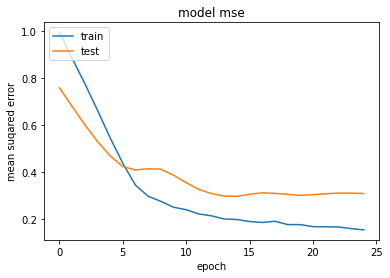

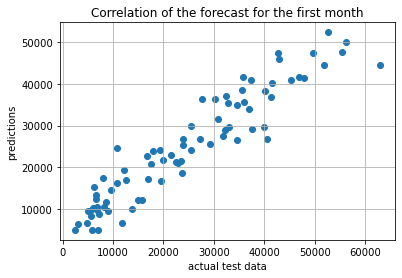

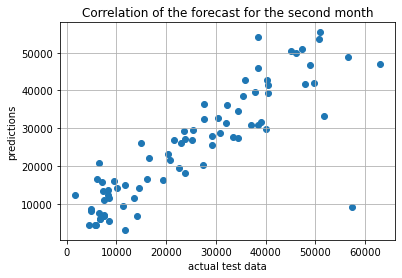

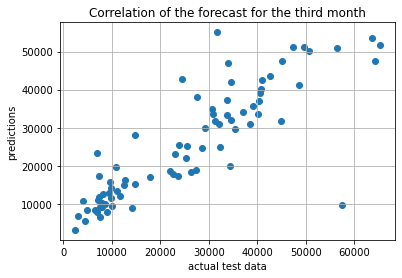

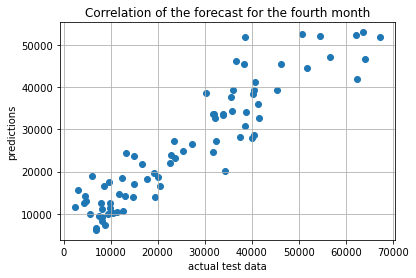

Pearsons correlation for the first month: 0.942
Pearsons correlation for the second month: 0.860
Pearsons correlation for the third month: 0.850
Pearsons correlation for the fourth month: 0.925
Mean Pearsons correlation: 0.894


In [161]:
X_Data, y_Data_comp = create_sequences(dataset, n_steps, output_len, dropNan)

# Get the places that we wanna predict
places = dataset.columns[:28]

# Iterator over different places
#for idx in np.arange(len(places)):
idx = 15
place = places[idx]
print("Start training model for: ",place)

y_Data = y_Data_comp[:,:,idx]

# Test train split
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)

# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

# Scale input data
xscalers = {}
X_train_scaled = X_train
X_test_scaled = X_test
for i in range(X_train.shape[2]):
    xscalers[i] = StandardScaler()
    X_train_scaled[:, :, i] = xscalers[i].fit_transform(X_train[:, :, i])

for i in range(X_train.shape[2]):
    X_test_scaled[:, :, i] = xscalers[i].transform(X_test[:, :, i])

# Scale output data
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)
y_test_scaled = yscaler.transform(y_test)

# Save the standard scaler
if not os.path.exists('../data_scaler'):
    os.makedirs('../data_scaler')
dump(xscalers, open('../data_scaler/xscalers.pkl', 'wb'))

if not os.path.exists('../data_scaler/yscaler'):
    os.makedirs('../data_scaler/yscaler')
dump(yscaler, open('../data_scaler/yscaler/{}.pkl'.format(place), 'wb'))

# Parameters for model setup
n_feats = X_train.shape[2]
n_fore = y_Data.shape[1]
# Setup model logging
if logging:
    run_name = place
    mlflow.start_run(experiment_id=experiment_id, run_name=run_name)

    mlflow.keras.autolog()

# Create and build the model
model = build_model_lstm(n_steps,n_feats,n_fore)
#model.summary()

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    batch_size=100,
    epochs=1000,
    verbose=0,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

# Save the model
model.save('../ML_models/{}.h5'.format(place))

# summarize history for accuracy
fig = plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
Figure = "../img/val_mean_squared_error.png"
fig.savefig(Figure)
if logging:
    mlflow.log_artifact(Figure)
else:
    plt.show()

#fig = plt.figure()
#plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_mean_absolute_error'])
#plt.title('model mae')
#plt.ylabel('mean absolute error')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#Figure = "../img/val_mean_absolute_error.png"
#fig.savefig(Figure)
#if logging:
#    mlflow.log_artifact(Figure)
#else:
#    plt.show()

#fig = plt.figure()
#plt.plot(history.history['mean_absolute_percentage_error'])
#plt.plot(history.history['val_mean_absolute_percentage_error'])
#plt.title('model mean absolute percentage error')
#plt.ylabel('mean absolute percentage error')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#Figure = "../img/val_mean_absolute_percentage_error.png"
#fig.savefig(Figure)
#if logging:
#    mlflow.log_artifact(Figure)
#else:
#    plt.show()

#fig = plt.figure()
#plt.plot(history.history['cosine_proximity'])
#plt.plot(history.history['val_cosine_proximity'])
#plt.title('model cosine proximity')
#plt.ylabel('cosine proximity')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#Figure = "../img/val_cosine_proximity.png"
#fig.savefig(Figure)
#if logging:
#    mlflow.log_artifact(Figure)
#else:
#    plt.show()

# Create Predictions
y_pred_train = yscaler.inverse_transform(model.predict(X_train_scaled))
y_pred_test = yscaler.inverse_transform(model.predict(X_test_scaled))

# Visualize the predicted data
month = ["first", "second", "third", "fourth"]
for i in np.arange(y_pred_test.shape[1]):
    fig = plt.figure()
    plt.scatter(y_test[:, i], y_pred_test[:, i])
    plt.grid(True)
    plt.title("Correlation of the forecast for the " + month[i] + " month")
    plt.xlabel("actual test data")
    plt.ylabel("predictions")
    Figure = "../img/correlation_{}.png".format(month[i])
    fig.savefig(Figure)
    if logging:
        mlflow.log_artifact(Figure)
    else:
        plt.show()

# Calculate Pearson's correlation
li = []
for i in np.arange(y_pred_test.shape[1]):
    corr, _ = pearsonr(y_test[:, i], y_pred_test[:, i])
    li.append(corr)
    print('Pearsons correlation for the',month[i],'month: %.3f' % corr)
    if logging:
        param_name = month[i]+"_pearson_correlation"
        mlflow.log_param(param_name, corr)

# Calcuate the mean Pearson's correlation
corr_mean = np.mean(li)
print('Mean Pearsons correlation: %.3f' % corr_mean)
if logging:
    mlflow.log_param("mean_pearson_correlation", corr_mean)

# End logging
if logging:
    mlflow.end_run()